In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from datasets import train_test_random_split, load_dsprites, CustomDataset
from train import train_factor_vae, test_factor_vae

In [2]:
dataset = load_dsprites("../datasets/dsprites.npz",False)
imgs = dataset["imgs"]

In [3]:
data_size = 10000
data = CustomDataset(imgs,data_size)

In [4]:
data_train, data_test = train_test_random_split(data, 0.8)

In [5]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

In [6]:
model = FactorVAEDSprites()
discriminator = Discriminator(nb_layers=4,hidden_dim=500)
vae_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
gamma = 0
epochs = 10

In [7]:
train_losses_list, recon_losses_list, kl_divs_list, tc_losses_list, discriminator_losses_list = train_factor_vae(model, discriminator, epochs, train_loader, vae_optimizer, discriminator_optimizer, gamma, 'bernoulli')

/Users/ireneburger/opt/anaconda3/envs/practical-atiml/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 855.2832485351563, recon loss: 850.9415161132813, kl div: 4.341733911784831, TC loss: 0.5539914682134985, discriminator loss: 0.49400968408584595
Epoch 1 finished, loss: 574.3724868164062, recon loss: 572.9849897460938, kl div: 1.3874957356452942, TC loss: 0.9714421055316925, discriminator loss: 0.4418581459522247
Epoch 2 finished, loss: 572.401931640625, recon loss: 571.2926513671875, kl div: 1.1092803173065187, TC loss: 0.9740899579524994, discriminator loss: 0.48310008573532104
Epoch 3 finished, loss: 571.8585654296875, recon loss: 571.1386638183594, kl div: 0.7199018175601959, TC loss: 0.48827200938761234, discriminator loss: 0.599361515045166
Epoch 4 finished, loss: 563.0446259765625, recon loss: 562.4377390136718, kl div: 0.6068887073993683, TC loss: 0.5401704404503107, discriminator loss: 0.5690361928939819
Epoch 5 finished, loss: 514.6226015625, recon loss: 513.1368679199219, kl div: 1.4857336730957031, TC loss: 2.6739257888793944, discriminator loss: 0.

In [8]:
def plot_loss(loss_list, title):
    plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

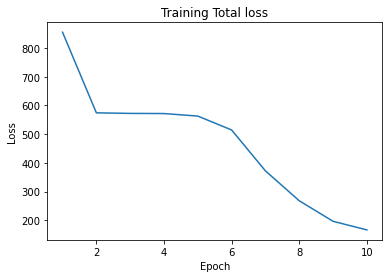

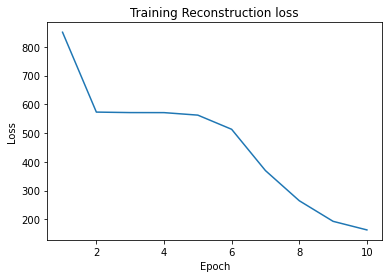

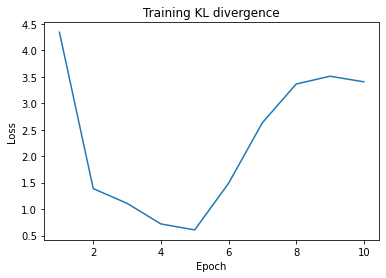

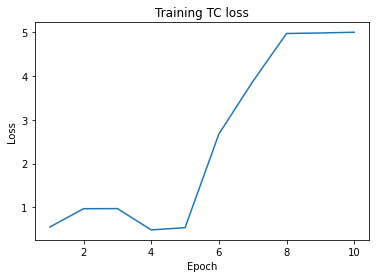

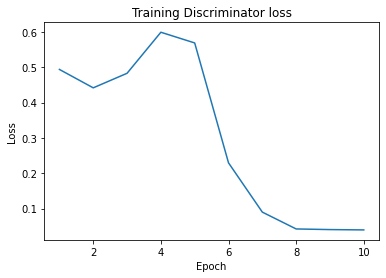

In [9]:
plot_loss(train_losses_list, "Total loss")
plot_loss(recon_losses_list, "Reconstruction loss")
plot_loss(kl_divs_list, "KL divergence")
plot_loss(tc_losses_list, "TC loss")
plot_loss(discriminator_losses_list, "Discriminator loss")

In [10]:
test_factor_vae(model, discriminator, test_loader, gamma, 'bernoulli')

/Users/ireneburger/opt/anaconda3/envs/practical-atiml/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test loss: 158.2390022277832


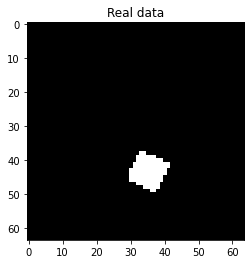

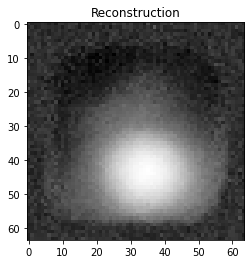

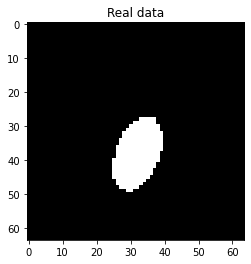

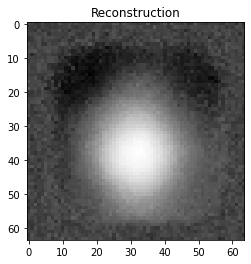

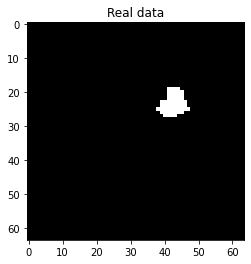

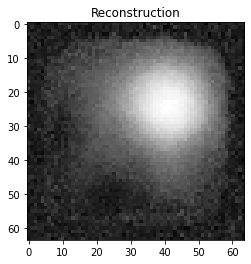

In [11]:
with torch.no_grad():
    for i in [1,15,20]:
        data, _ = data_test[i]
        data = data.float()
        recon, mu, logvar, z = model(data)
        plt.imshow(data, cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(recon.squeeze(), cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()

In [12]:
dataset.allow_pickle = True
latents_sizes = dataset['metadata'][()][b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1, fixed = None):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        if fixed == lat_i:
            fixed_value = np.random.randint(lat_size, size=1)
            samples[:, lat_i] = np.full(size, fixed_value)
        else:
            samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

In [13]:
def compute_latent_variance(size):
    sample = sample_latent(size)
    imgs_sampled = imgs[latent_to_index(sample)]
    latents = np.zeros((size,10))
    for i,data in enumerate(imgs_sampled):
        data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
        recon, mu, logvar, z = model(data)
        z = np.array(z.squeeze().detach().numpy())
        latents[i] = z
    global_vars = np.var(latents, axis = 0) 
    return global_vars

latents_global_variance = compute_latent_variance(1000)


In [14]:
def FactorVAE_entanglement_metric(nb_samples,sample_size):
    loss = 0
    classification = np.zeros((len(latents_sizes),10))
    for i in range(nb_samples):
        k = np.random.randint(len(latents_sizes)-1)+1
        latents_sampled = sample_latent(size=sample_size, fixed=k)
        indices_sampled = latent_to_index(latents_sampled)
        imgs_sampled = imgs[indices_sampled]
        latents_rep = np.zeros((sample_size,10))
        for data in imgs_sampled:
            data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
            recon, mu, logvar, z = model(data)
            z = np.array(z.squeeze().detach().numpy())
            latents_rep[i] = z
        latents_var = np.var(latents_rep, axis = 0) 
        latents_var_normalized = np.divide(latents_var, latents_global_variance)
        idx = np.argmin(latents_var_normalized)
        classification[k,idx]+=1
    print(classification)
    for i in range(len(latents_sizes)):
        loss = loss + np.sum(classification[i])- np.max(classification[i])
    return loss/nb_samples

In [ ]:
FactorVAE_entanglement_metric(50,500)